# Particle rotation notebook 

This notebook demonstrates how the rotation of an asymmetric particle can make the particle appear as different shapes, and, if enough rotations are considered, will form a single circular structure.

To do this, I load a simple image, rotate it to a number, n, of random angles (theta) and add the images together. This process can be performed starting with the initial image each time, or rotating sequentially (which is the more realistic process). 

## Import dependancies

In [1]:
import cv2 
import numpy as np
import matplotlib.pyplot as plt
import random
plt.gray()

<Figure size 640x480 with 0 Axes>

## Load image

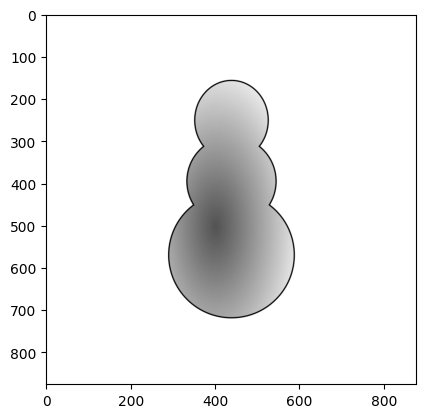

In [2]:
im = cv2.imread('Rotation_demo.png')
im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
plt.imshow(im)
plt.show()

## Invert image 

When I rotate an image, the region region outside the image is by default black, the easiest way to fix this, considering I have a white background already is to invert the image. I will invert the image again at the end. 

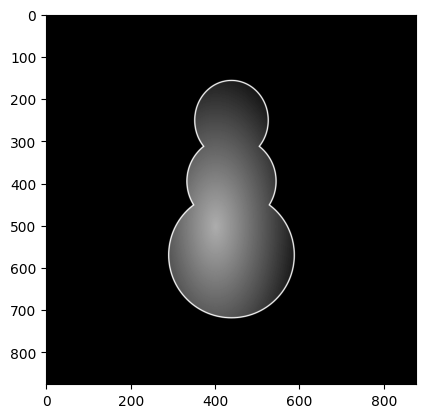

In [3]:
im = cv2.bitwise_not(im)
plt.imshow(im)
plt.show()

## Define Rotation


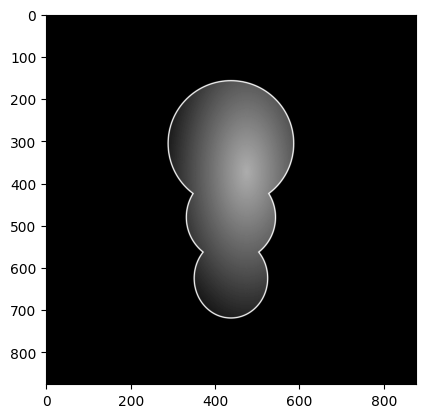

In [4]:
height, width = im.shape

centerX, centerY = (width // 2, height // 2) #setting the pivot to the centre of the image

M = cv2.getRotationMatrix2D((centerX, centerY), -180, 1.0) #Create rotation

rotated = cv2.warpAffine(im, M, (width, height)) # Rotate Image

plt.imshow(rotated)
plt.show()

## Randomise rotation

I want to make a random rotation value, ranging from zero to a defined value (`max_rotation`).

This could be done using random.randint(), but performing `random.random()*max_rotation` means it does not have to be an integer.

I'm also randomising if the rotation is positive or negative (clockwise or anticlockwise). 


In [5]:
max_rotation = 180
rotation = random.random()*max_rotation

if random.random()>0.5:
    rotation = -rotation

print(rotation)

140.37769606484


## Loop this n times and create a function

I'm doing non-sequentially and sequentially. By sequentially I mean that each rotation is made from the previous image. Non-sequentially on the other hand means that the rotation is made beginning from the initial image. 

In [7]:
n = 100
def create_rotations(n, max_rotation):
    rotated_ims = []
    for x in range(n):
        rotation = random.random()*max_rotation
        if random.random()>0.5:
            rotation = -rotation
        M = cv2.getRotationMatrix2D((centerX, centerY), rotation, 1.0)
        rotated = cv2.warpAffine(im, M, (width, height))
        
        rotated_ims.append(rotated)
    new_im = np.sum(np.array(rotated_ims), axis=0)
    new_im = cv2.bitwise_not(new_im)
    new_im = convert8bit(new_im) 
    
    return new_im

In [8]:
def create_rotations_sequential(n, max_rotation):
    rotated_ims = [im]
    for x in range(n):
        rotation = random.random()*max_rotation
        if random.random()>0.5:
            rotation = -rotation
        M = cv2.getRotationMatrix2D((centerX, centerY), rotation, 1.0)
        rotated = cv2.warpAffine(rotated_ims[-1], M, (width, height))
        
        rotated_ims.append(rotated)
    new_im = np.sum(np.array(rotated_ims), axis=0)
    new_im = cv2.bitwise_not(new_im)
    new_im = convert8bit(new_im) 
    
    return new_im

## Define convert to 8bit 

To save the images, the values need to range from 0-255, so this function performs this adjustment. This function also makes sure each image is on the same scale. 

In [9]:
def convert8bit(noisy_frames):
    frames8bit = (noisy_frames - noisy_frames.min()) * (
                1 / (noisy_frames.max() - noisy_frames.min()) * 255
            )
    return frames8bit

## Plot the results - Non-sequential


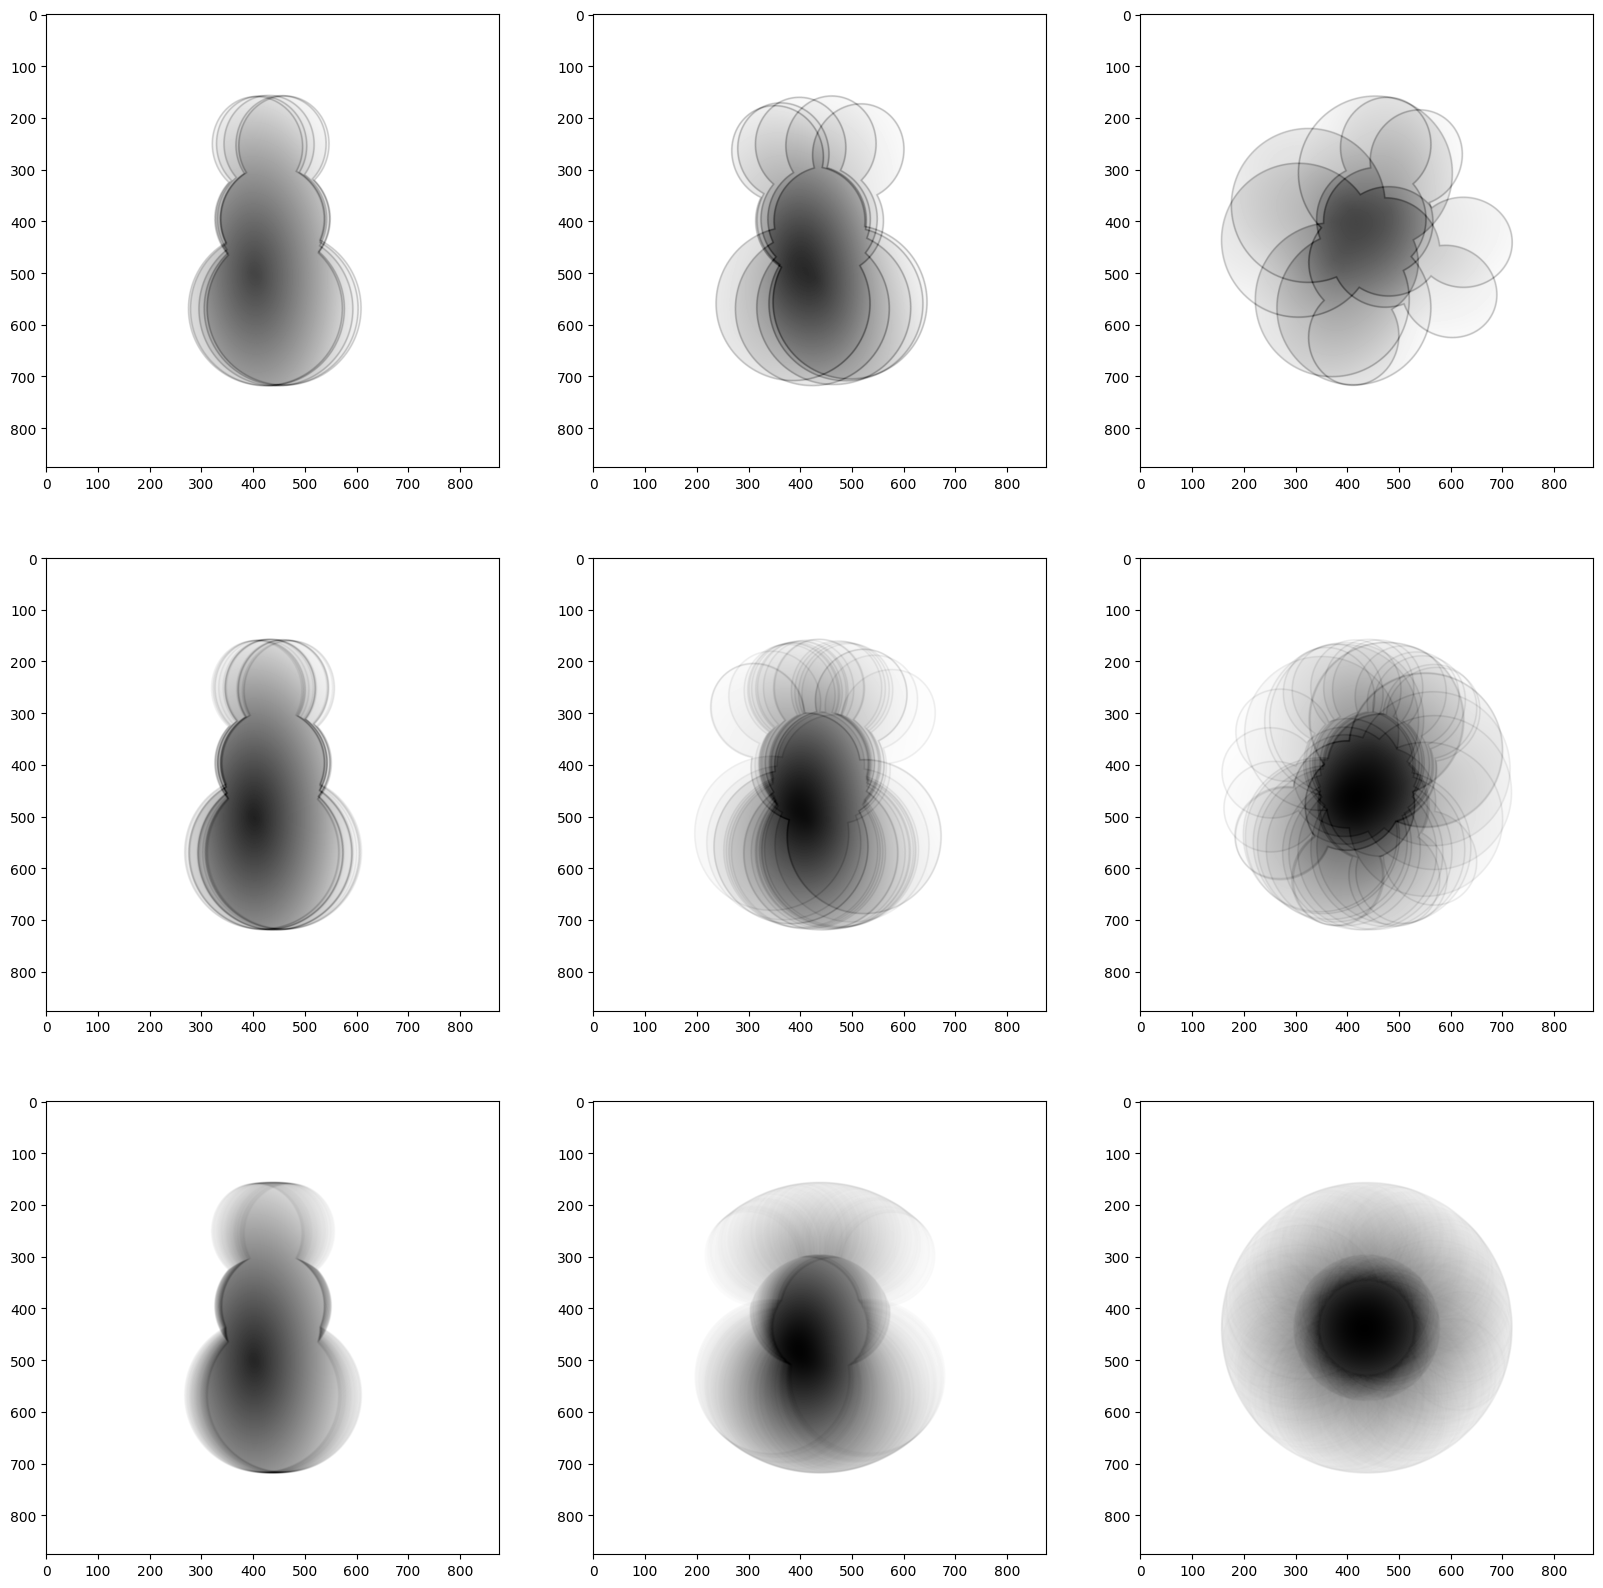

In [10]:
ns = [5, 20, 1000]
max_rotations = [10, 45, 180]

fig, axes = plt.subplots(3,3, figsize=(20,20))

for i, max in enumerate(max_rotations):
    axes[0][i].imshow(create_rotations(ns[0], max))
    axes[1][i].imshow(create_rotations(ns[1], max))
    axes[2][i].imshow(create_rotations(ns[2], max))

plt.show()

## Plot results - sequential

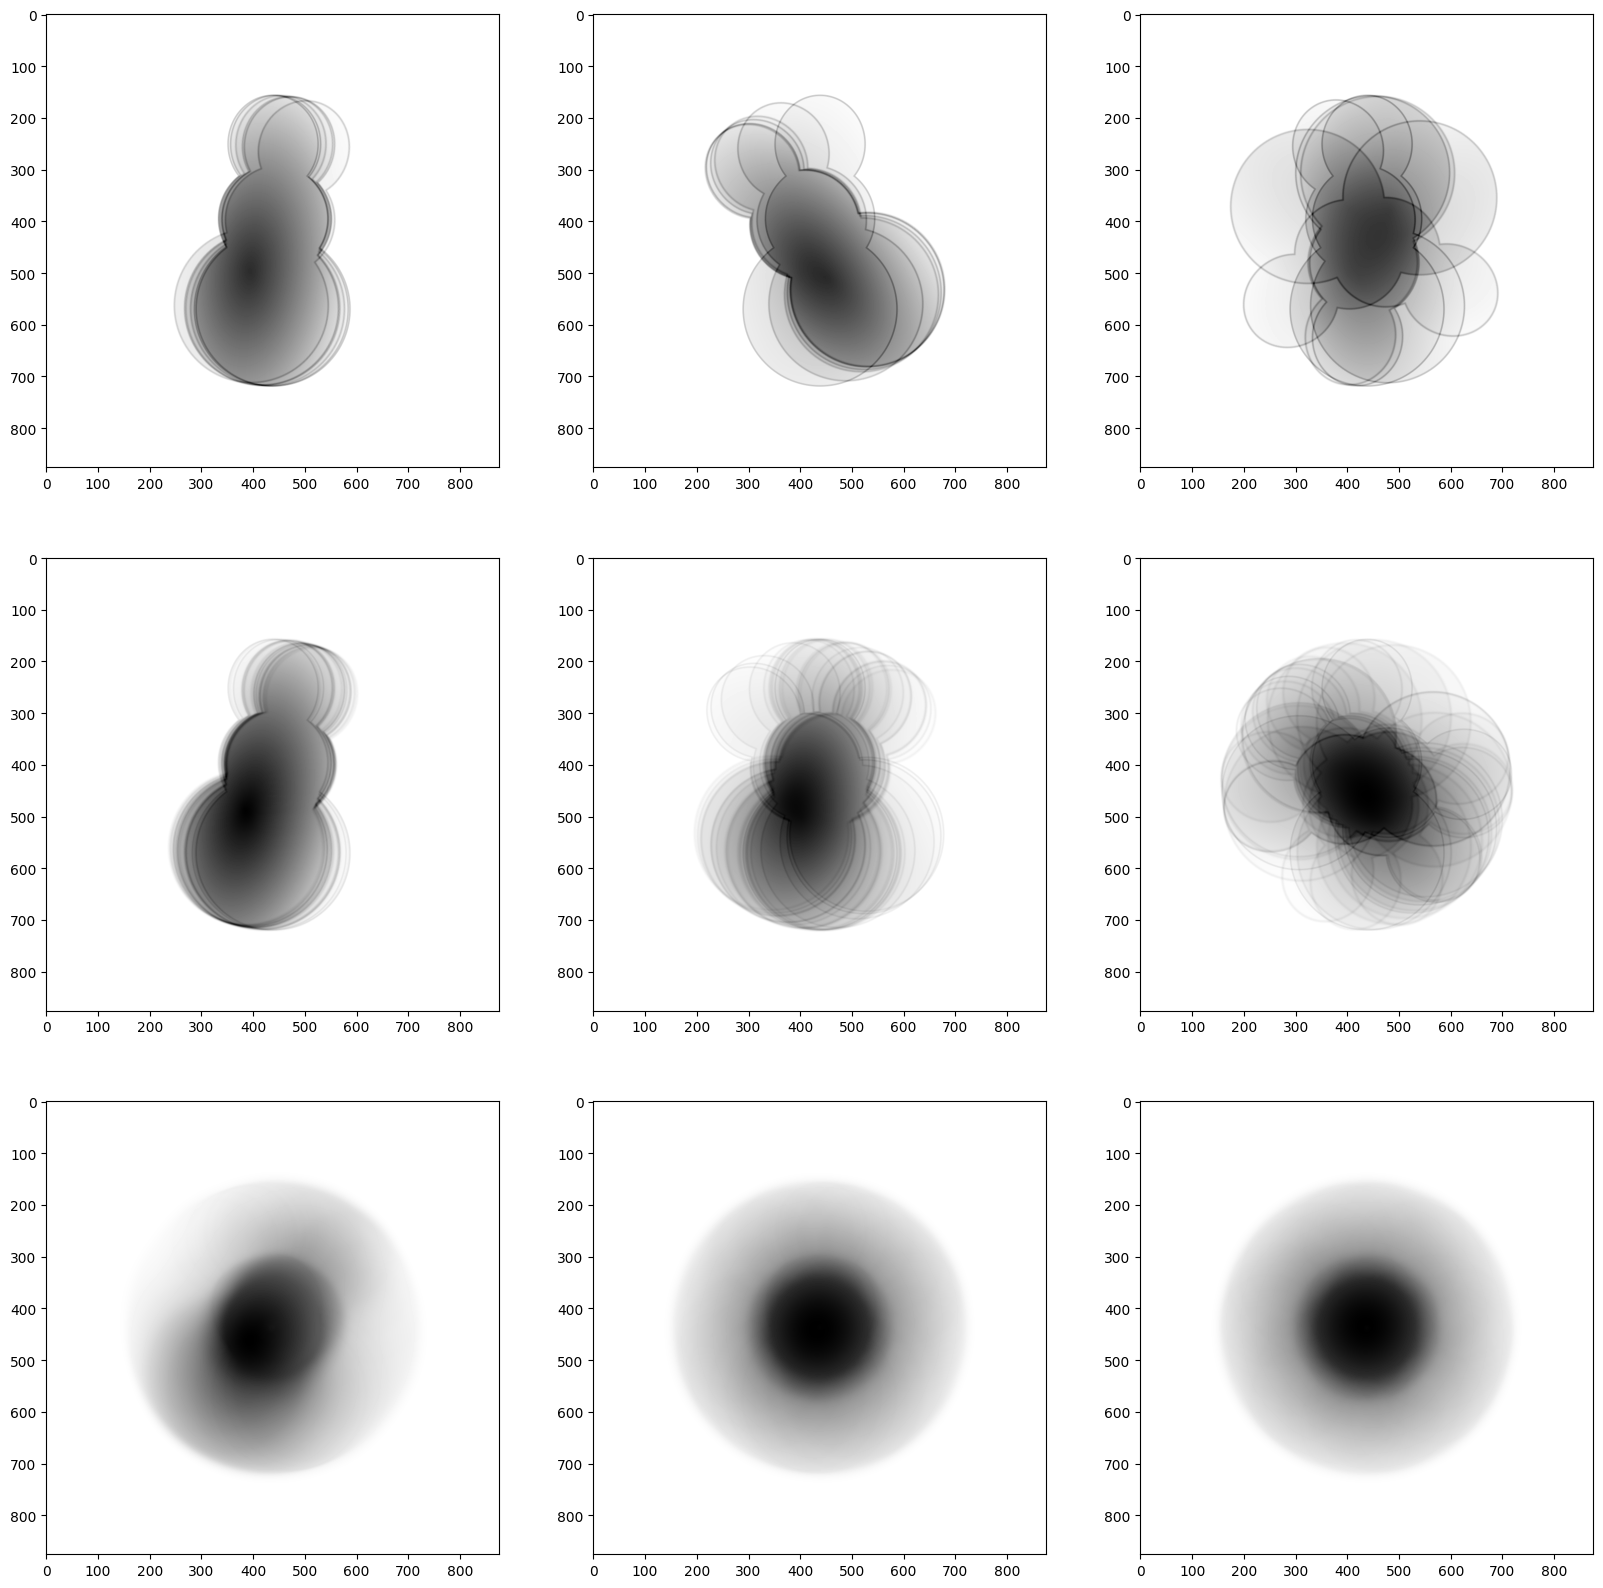

In [11]:
ns = [5, 20, 1000]
max_rotations = [10, 45, 180]

fig, axes = plt.subplots(3,3, figsize=(20,20))

for i, max in enumerate(max_rotations):
    axes[0][i].imshow(create_rotations_sequential(ns[0], max))
    axes[1][i].imshow(create_rotations_sequential(ns[1], max))
    axes[2][i].imshow(create_rotations_sequential(ns[2], max))

plt.show()

## Write the output images

In [25]:
cv2.imwrite('Image_rotation_1000_10.png', create_rotations(1000, 10))

True

In [45]:
for n in [5, 20, 1000]:
    cv2.imwrite(f'Image_rotation_{n}_10.png', create_rotations(n, 10))
    cv2.imwrite(f'Image_rotation_{n}_45.png', create_rotations(n, 45))
    cv2.imwrite(f'Image_rotation_{n}_180.png', create_rotations(n, 180))

In [47]:
for n in [5, 20, 1000]:
    cv2.imwrite(f'Sequential_Image_rotation_{n}_10.png', create_rotations_sequential(n, 10))
    cv2.imwrite(f'Sequential_Image_rotation_{n}_45.png', create_rotations_sequential(n, 45))
    cv2.imwrite(f'Sequential_Image_rotation_{n}_180.png', create_rotations_sequential(n, 180))

## What happens if you average together many rotated sums?

Lets say, hypothetically, that you had a large number of images of the same asymmetric particle that had rotated during imaging, giving a variety of shapes as seen above (particularly at low n values). Can you get the original image back? 

For this I am going to assume minimal rotation (+/- 2 degrees max) and sequential rotation.

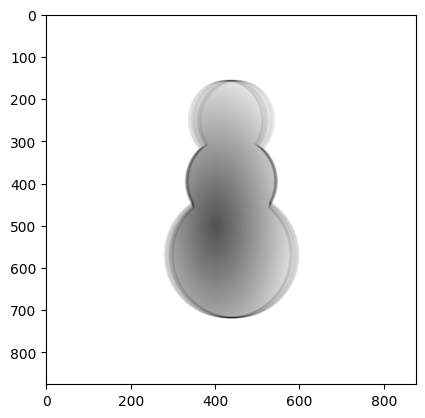

In [40]:
#Show rotated image (one random example of)
plt.imshow(create_rotations(100,5))
plt.show()

In [42]:
cv2.imwrite('Rotation_5degrees_n100.png',create_rotations(100, 5))


True

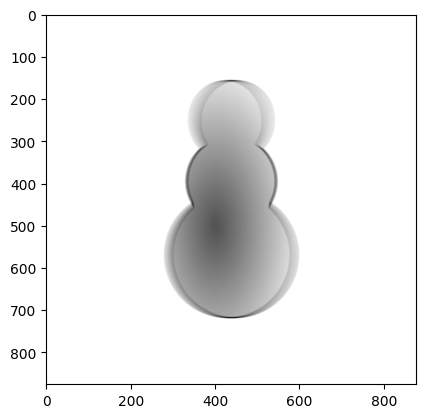

True

In [41]:
set_ims = []
for x in range(200):
    
    set_ims.append(create_rotations(100, 5))

new_im = np.sum(np.array(set_ims), axis=0)
new_im = convert8bit(new_im)
plt.imshow(new_im)
plt.show()

cv2.imwrite('Sum_of_200rotations_2degrees_n100.png', new_im)

It does not appear to be improved by this process, suggesting if the resolution is lost in the original image due to rotation, it may be impossible to retrieve it.

## What happens if the pivot moves slightly?

In [31]:

def create_rotations_variable_pivot(n, max_rotation, pivot_variation):
    rotated_ims = [im]
    for x in range(n):
        rotation = random.random()*max_rotation
        if random.random()>0.5:
            rotation = -rotation

        if random.random()>0.5:
            newCenterX= im.shape[0]//2+pivot_variation*random.random()
        else:
            newCenterX= im.shape[0]//2-pivot_variation*random.random()
        if random.random()>0.5:
            newCenterY= im.shape[1]//2+pivot_variation*random.random()
        else:
            newCenterY= im.shape[1]//2-pivot_variation*random.random()
        #print(centerX, centerY)
        #print(newCenterX, newCenterY)
        
        M = cv2.getRotationMatrix2D((newCenterX, newCenterY), rotation, 1.0)
        rotated = cv2.warpAffine(im, M, (width, height))
        
        rotated_ims.append(rotated)
    new_im = np.sum(np.array(rotated_ims), axis=0)
    new_im = cv2.bitwise_not(new_im)
    new_im = convert8bit(new_im) 
    
    return new_im

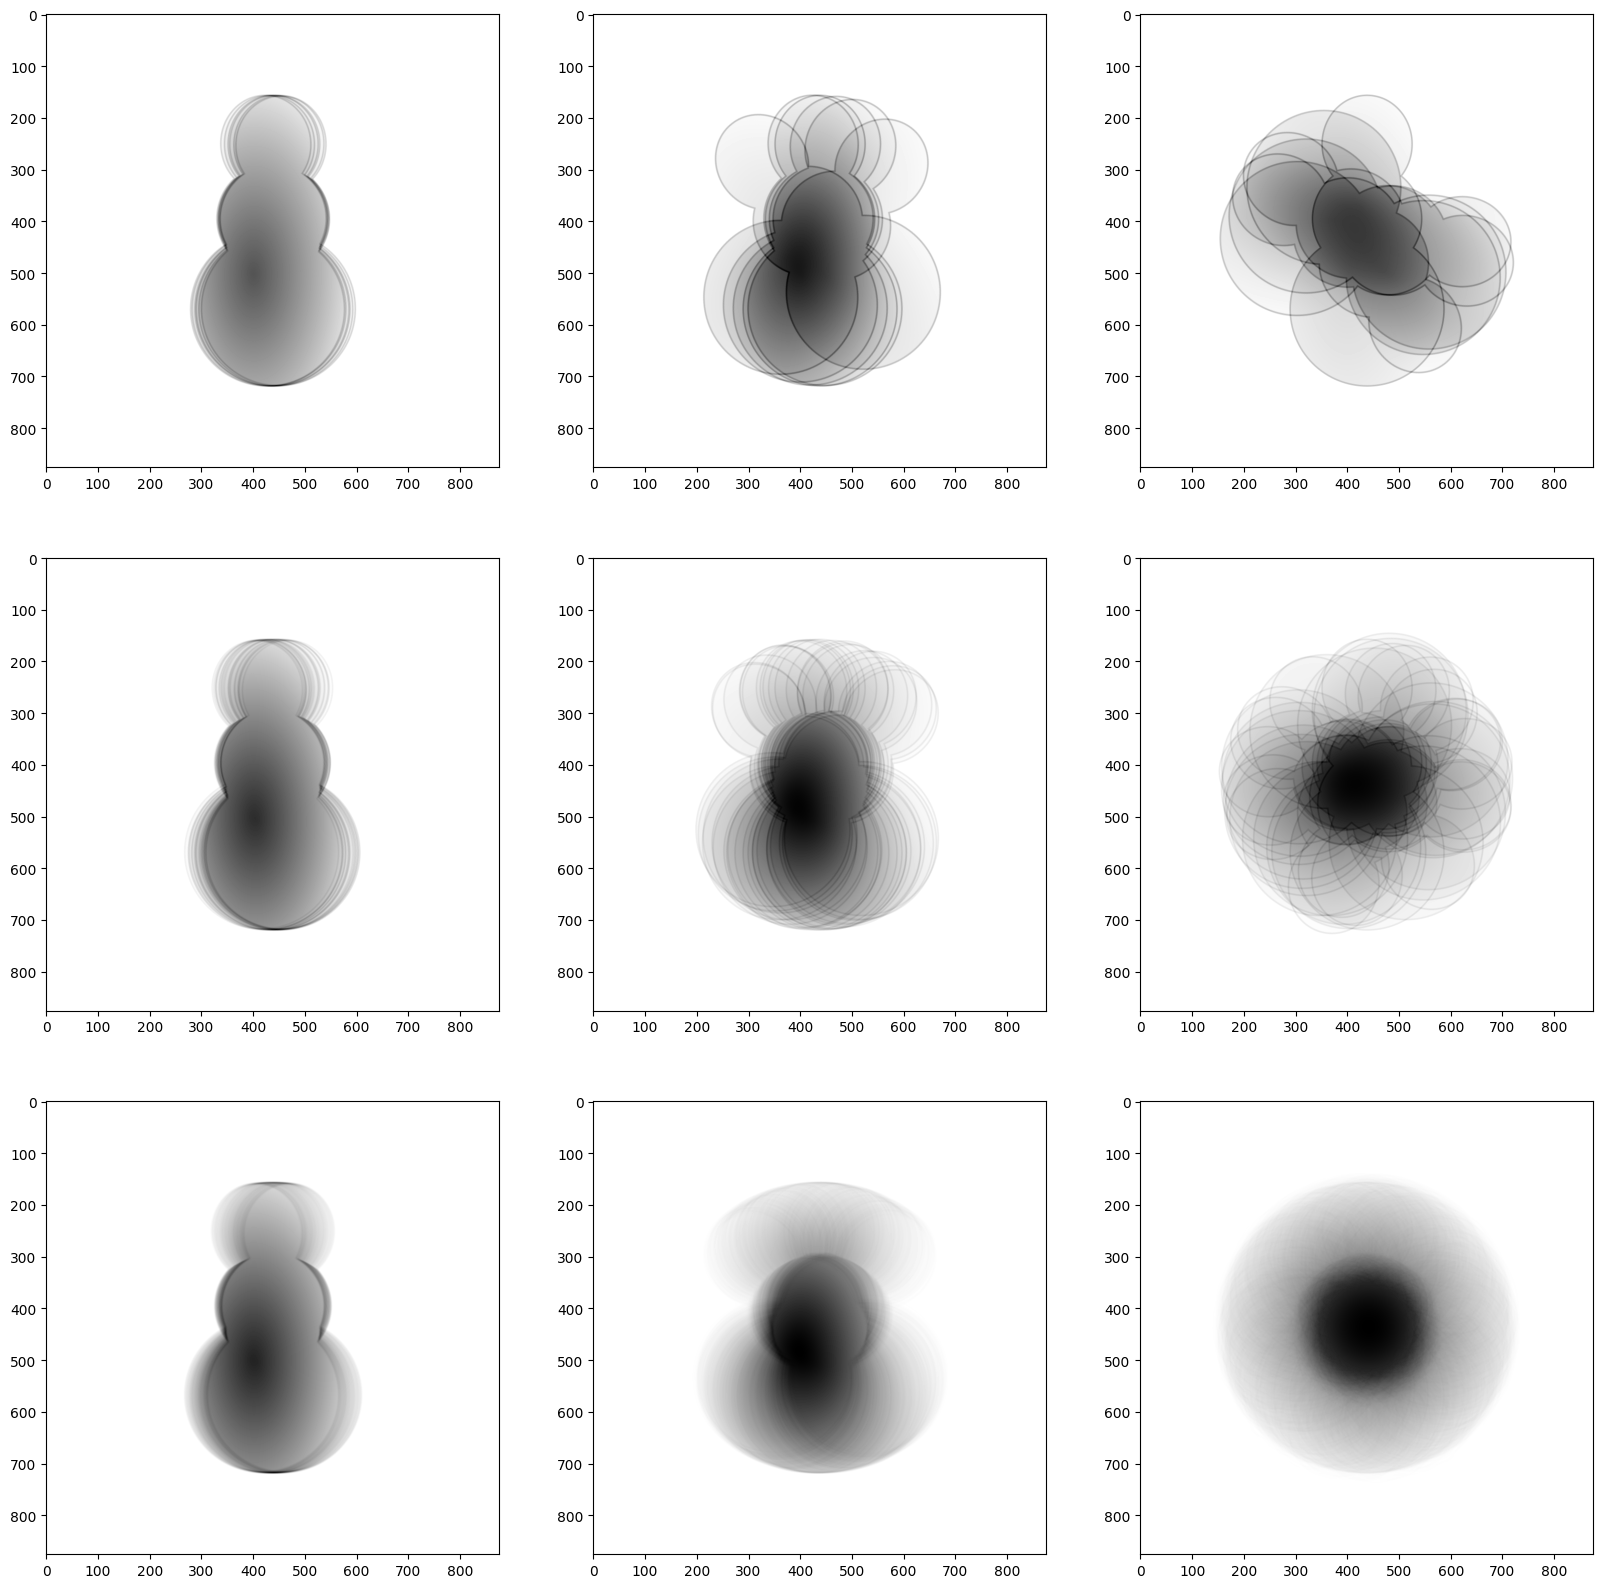

In [34]:
ns = [5, 20, 1000]
max_rotations = [10, 45, 180]

fig, axes = plt.subplots(3,3, figsize=(20,20))

for i, max in enumerate(max_rotations):
    axes[0][i].imshow(create_rotations_variable_pivot(ns[0], max, 10))
    axes[1][i].imshow(create_rotations_variable_pivot(ns[1], max,10))
    axes[2][i].imshow(create_rotations_variable_pivot(ns[2], max, 10))

plt.show()